# Advanced Statistics: Homework 2
Travelling Salesman with Simulated Annealing

Author: Andrey Kulagin

In [1]:
import numpy as np
import pandas as pd
import geopy.distance # to calculate distances between geo-points

import math

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from matplotlib import rc
# from IPython.display import HTML

rc('animation', html='html5')

In [2]:
data = pd.read_csv('cities_corrected.csv')

In [3]:
data = data[['Город', 'Широта', 'Долгота', 'Население']]

### Leave only top 30 cities by population

In [4]:
n = 30

In [5]:
data.sort_values(by='Население', ascending=False, inplace=True)
data.reset_index(drop=True, inplace=True)

In [6]:
data.head()

,Город,Широта,Долгота,Население
0,Москва,55.753879,37.620373,11514330
1,Санкт-Петербург,59.939125,30.315822,4848742
2,Новосибирск,55.028102,82.921057,1498921
3,Екатеринбург,56.838633,60.605489,1377738
4,Нижний Новгород,56.324209,44.005395,1250615


In [7]:
data = data.iloc[:n]

In [8]:
data.shape

(30, 4)

### Calculate pairwise distance between cities

In [9]:
d = np.zeros(shape=(n, n))

for i in range(n):
    for j in range(n):
        city_i = data.iloc[i][['Широта', 'Долгота']].tolist()
        city_j = data.iloc[j][['Широта', 'Долгота']].tolist()
        d[i, j] = geopy.distance.vincenty(city_i, city_j).km

In [10]:
city_name_to_idx = pd.Series(data.index, index=data['Город']).to_dict()

In [11]:
d[city_name_to_idx['Казань'], city_name_to_idx['Москва']]

720.3279413667203

### Add cities to the map

In [12]:
xx = data['Долгота'].values
yy = data['Широта'].values

In [13]:
def get_total_distance(path):
    result = 0
    for i in range(n-1):
        result += d[path[i], path[i+1]]
    return result

In [14]:
# initial path
path = list(np.random.choice(np.arange(n), size=n, replace=False))

In [15]:
get_total_distance(path)

62289.03065648417

### Random initial plot

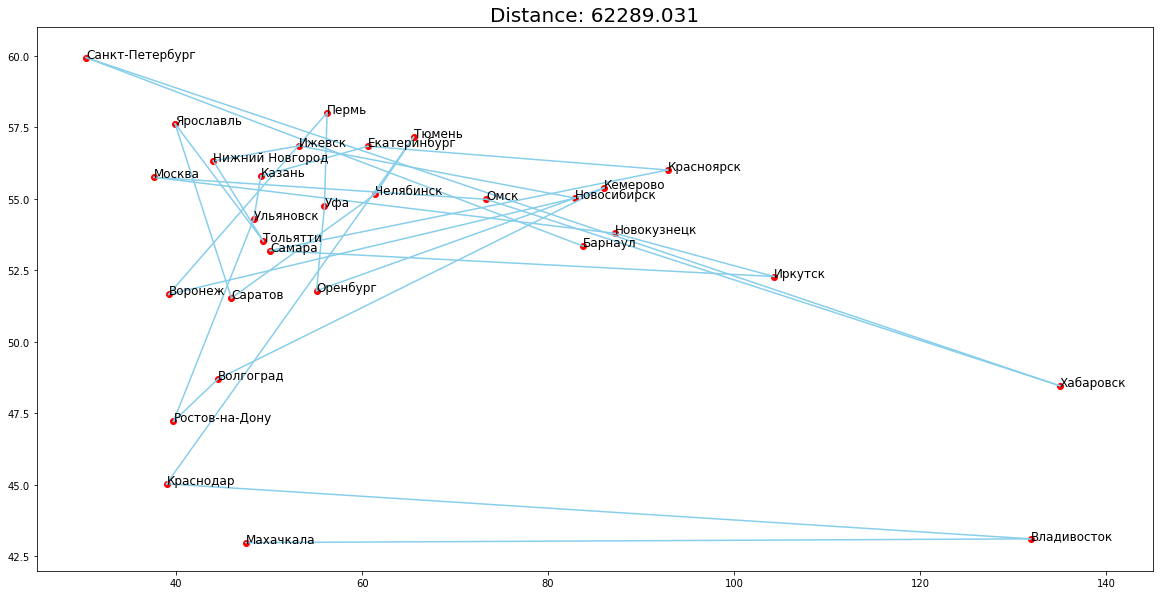

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlim(25, 145)
ax.set_ylim(42, 61)

ax.scatter(xx, yy, color='red')
for i in range(n):
    ax.text(xx[i], yy[i], data.iloc[i]['Город'], fontsize=12)


ax.set_title(f'Distance: {get_total_distance(path):.3f}', fontsize=20)
             
for i in range(n-1):
    ax.plot(xx[[path[i], path[i+1]]], yy[[path[i], path[i+1]]], color='skyblue')

In [17]:
# energy distribution
def p_star(dist, T):
    return np.exp(-dist/T)

In [18]:
def run_simulation(init_temp, max_iter, annealing_rate):
    # initial random path
    path = list(np.random.choice(np.arange(n), size=n, replace=False))
    
    params = {
        'path': path,
        'T': init_temp,
        'distance': get_total_distance(path),
        'distance_list': [],
        'T_list': [],
    }

    fig, ax = plt.subplots(figsize=(20, 10))

    ax.set_xlim(25, 145)
    ax.set_ylim(42, 61)

    ax.scatter(xx, yy, color='red')
    for i in range(n):
        ax.text(xx[i], yy[i], data.iloc[i]['Город'], fontsize=12)

    line = Line2D(xx[path], yy[path], color='skyblue')
    ax.add_artist(line)

    def update(frame, params):
        new_path = params['path'].copy()
        i, j = np.random.choice(np.arange(n), size=2, replace=False)
        new_path[i], new_path[j] = new_path[j], new_path[i] # swap 2 random cities

        new_distance = get_total_distance(new_path)

        alpha = p_star(new_distance, params['T']) / p_star(params['distance'], params['T'])

        for_update = []

        if np.random.rand() <= alpha:
            params['path'] = new_path
            params['distance'] = new_distance
            line.set_data(xx[new_path], yy[new_path])
            for_update = [line]

        params['T_list'].append(params['T'])
        params['distance_list'].append(params['distance'])

        ax.set_title(f"Temp: {params['T']:8.3f}, Distance: {params['distance']:9.3f}", fontsize=20)

        params['T'] *= annealing_rate

        return for_update


    anim = FuncAnimation(fig, update, frames=max_iter, blit=True, fargs=(params,), interval=5)

    return anim, params['T_list'], params['distance_list']
    

In [19]:
init_temp = 10000.0
temp_end = 1.0

In [20]:
# how many iterations to cool down
def calc_iterations(annealing_rate, temp_init=init_temp, temp_end=temp_end):
    return int(math.ceil(math.log(temp_end / temp_init, annealing_rate)))

### annealing_rate = 0.99

In [21]:
rate0 = 0.99

In [22]:
iter0 = calc_iterations(rate0)
iter0

917

C:\Users\mrand\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


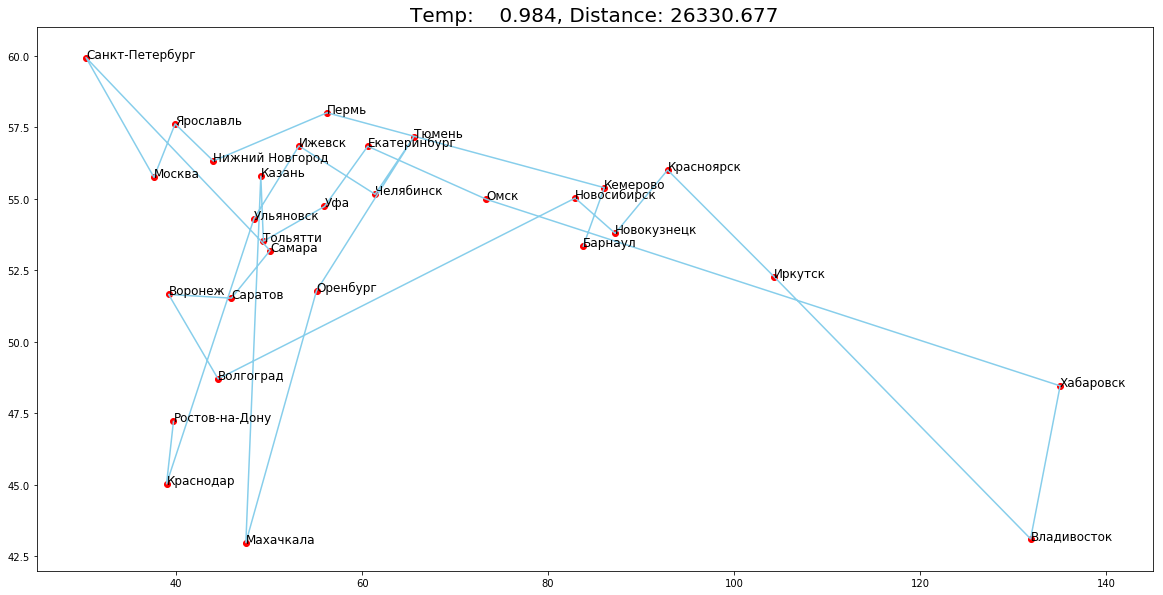

In [23]:
anim0, temp0, dist0 = run_simulation(init_temp, iter0, rate0)
anim0.save('rate_0.99.mp4')

### annealing_rate = 0.995

In [24]:
rate1 = 0.995

In [25]:
iter1 = calc_iterations(rate1)
iter1

1838

C:\Users\mrand\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


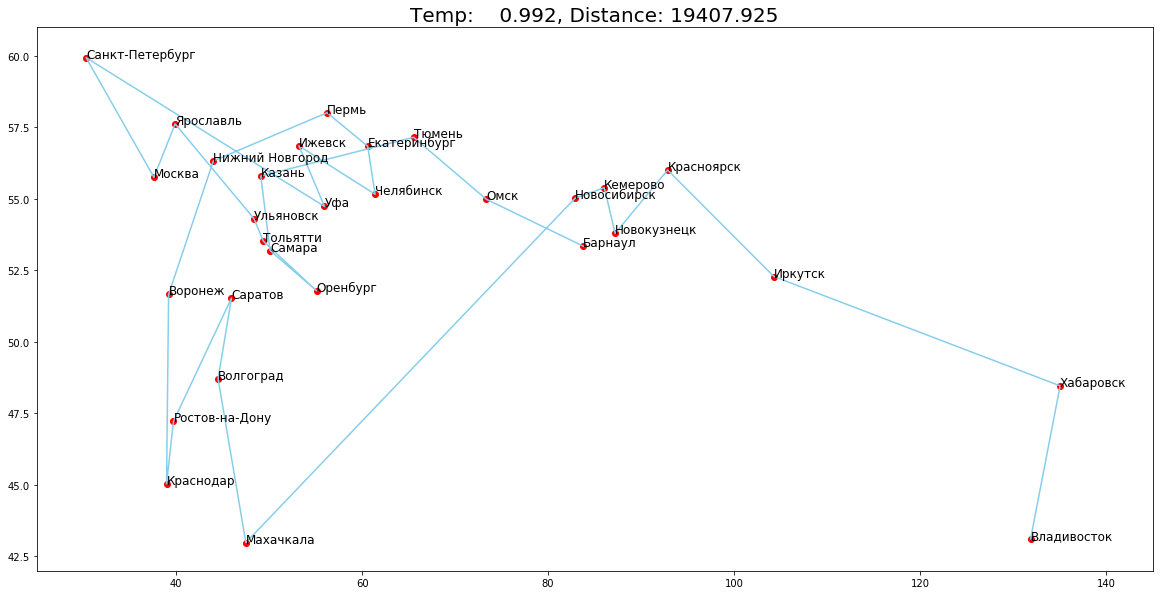

In [26]:
anim1, temp1, dist1 = run_simulation(init_temp, iter1, rate1)
anim1.save('rate_0.995.mp4')

### annealing_rate = 0.999

In [27]:
rate2 = 0.999

In [28]:
iter2 = calc_iterations(rate2)
iter2

9206

C:\Users\mrand\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


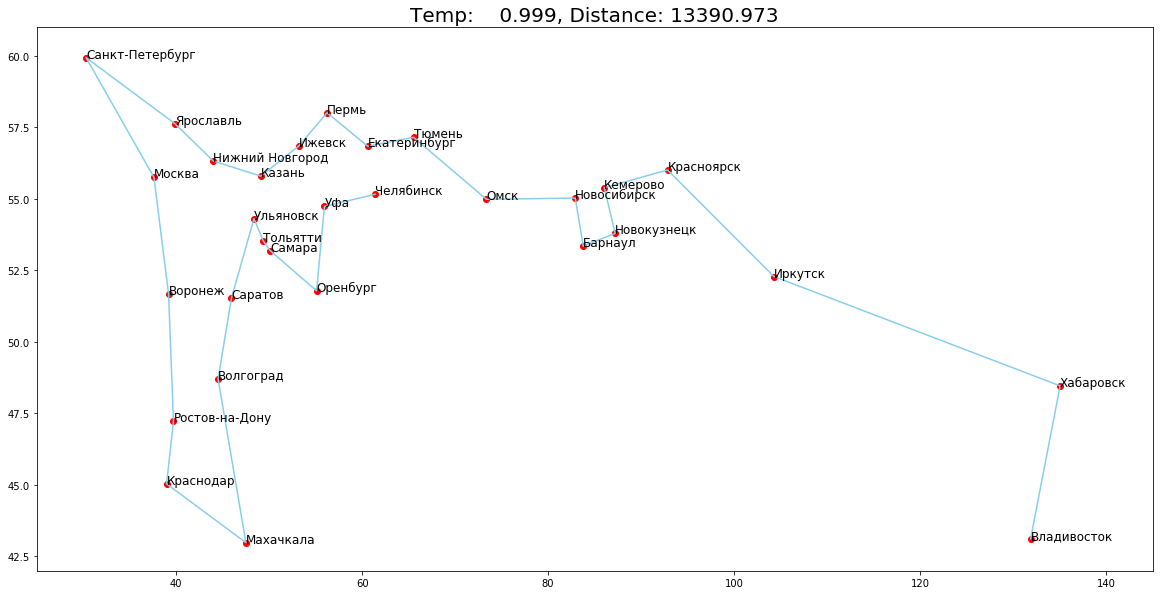

In [29]:
anim2, temp2, dist2 = run_simulation(init_temp, iter2, rate2)
anim2.save('rate_0.999.mp4')

In [31]:
temp0[-1], dist0[-1]

(0.9842572909771309, 26330.677130283777)

In [32]:
temp1[-1], dist1[-1]

(0.9923057122312577, 19407.92472301153)

In [30]:
temp2[-1], dist2[-1]

(0.9987346019647139, 13390.972921332304)

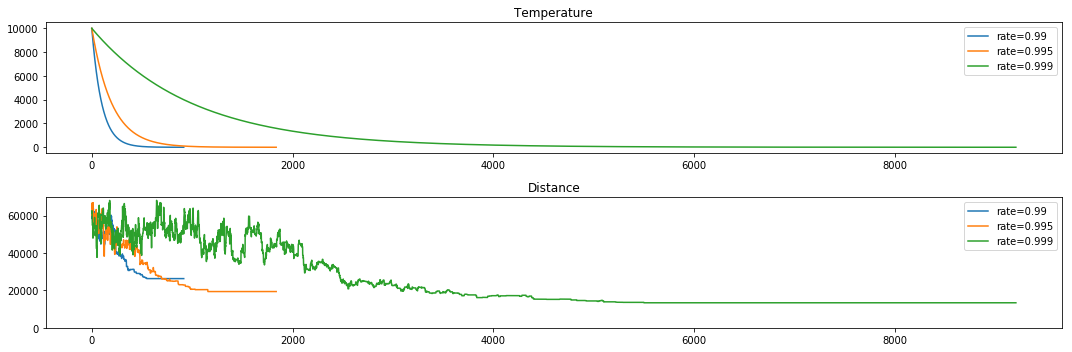

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5))


ax[0].set_title('Temperature')
ax[0].plot(np.arange(iter0), temp0[:iter0], label='rate=0.99')
ax[0].plot(np.arange(iter1), temp1[:iter1], label='rate=0.995')
ax[0].plot(np.arange(iter2), temp2[:iter2], label='rate=0.999')
ax[0].legend()


ax[1].plot(np.arange(iter0), dist0[:iter0], label='rate=0.99')
ax[1].plot(np.arange(iter1), dist1[:iter1], label='rate=0.995')
ax[1].plot(np.arange(iter2), dist2[:iter2], label='rate=0.999')
ax[1].set_title('Distance')
ax[1].set_ylim(0, 70000)
ax[1].legend()


fig.tight_layout()